In [1]:

import torch
from flextok.flextok_wrapper import FlexTokFromHub
from diffusers.models import AutoencoderKL
from flextok.utils.demo import imgs_from_urls
import matplotlib.pyplot as plt
from reconstruction_loss import reconstruction_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# this model contains the VAE and the denoiser
model = FlexTokFromHub.from_pretrained('EPFL-VILAB/flextok_d18_d28_in1k').eval().to(device)

In [3]:
from data.utils.dataloaders import get_imagenet_dataloader
imgnet_dataloader = get_imagenet_dataloader(batch_size=2)

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
first_images, first_labels = next(iter(imgnet_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6726604..2.535425].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


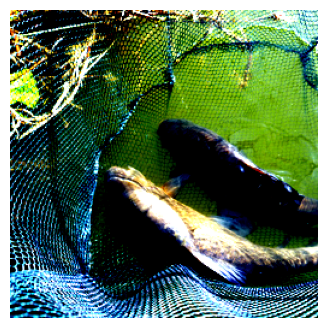

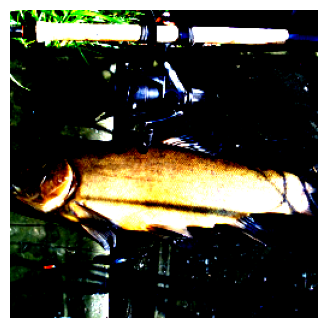

In [14]:
# print(first_images.shape) # torch.Size([2, 3, 256, 256])
# Show the first image
# in order to show, we first get the first image from the batch, then we permute the dimensions such that
# the channel dimension comes last: from (C, H, W) to (H, W, C). then we carry the tensor to CPU and convert it to numpy
# plt.imshow(first_images[0].permute(1, 2, 0).cpu().numpy())
# plt.imshow(first_images[1].permute(1, 2, 0).cpu().numpy())

# show the 2 images together

# Select two samples
for i in range(2):
    img = first_images[i]  # shape: (3, H, W)
    label = first_labels[i].item()

    # Convert to (H, W, 3) format for matplotlib
    img_np = img.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(4, 4))
    plt.imshow(img_np)
    plt.axis('off')


In [15]:
def reconstructionLoss_vs_compressionRate(model, images, k_keep_list, loss_fns, loss_weights=None):
    """
    Computes reconstruction losses for different compression rates.
    
    Args:
        model: FlexTok model instance.
        images: Tensor of shape (B, 3, H, W) with input images.
        k_keep_list: List of integers representing the number of tokens to keep.
        loss_fns: List of loss functions to compute.
        loss_weights: List of weights for each loss function.
    
    Returns:
        dict: Dictionary with compression rates as keys and total losses as values.
    """
    results = {}
    
    # First tokenize the images into register tokens, which already handles the VAE mapping to latents.
    tokens_list = model.tokenize(images.to(device))

    # we want to see how the reconstruction error changes with different compression rates.
    # lower k_keep means (fewer registers) more compression, higher k_keep means less compression.
    for k_keep in k_keep_list:
        # the first ":" means for all images in the batch, the second refers to the register tokens.
        # we keep only the first k_keep tokens.
        tokens_list_filtered = [t[:,:k_keep] for t in tokens_list]
        
        reconst = model.detokenize(
            tokens_list_filtered,
            timesteps=20,
            guidance_scale=7.5,
            perform_norm_guidance=True,
        )
        
        total_loss, loss_dict = reconstruction_error(reconst, images, 
            loss_fns=loss_fns,
            loss_weights=loss_weights
        )
        print(f"Compression rate k_keep={k_keep}: Total Loss = {loss_dict.values()}")
        
        results[k_keep] = loss_dict
    
    return results

In [ ]:
from reconstruction_loss import MAELoss, VGGPerceptualLoss


k_keep_list = [1, 4, 8, 16, 32, 64, 128, 200, 256]  # Different compression rates to test
loss_fns = [VGGPerceptualLoss().to(device), MAELoss()]
results = reconstructionLoss_vs_compressionRate(model, first_images.to(device), k_keep_list, loss_fns, loss_weights=None)

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 73.38 MiB is free. Including non-PyTorch memory, this process has 10.38 GiB memory in use. Process 1605340 has 12.22 GiB memory in use. Of the allocated memory 9.66 GiB is allocated by PyTorch, and 442.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 

Results: {1: {'VGGPerceptualLoss': 6.551492691040039, 'MAELoss': 1.007537841796875}, 4: {'VGGPerceptualLoss': 6.452919960021973, 'MAELoss': 0.8183573484420776}, 8: {'VGGPerceptualLoss': 6.328386306762695, 'MAELoss': 0.8001121282577515}, 16: {'VGGPerceptualLoss': 6.416606426239014, 'MAELoss': 0.7406759262084961}, 32: {'VGGPerceptualLoss': 6.438834190368652, 'MAELoss': 0.7039017081260681}, 64: {'VGGPerceptualLoss': 6.307858943939209, 'MAELoss': 0.6801621913909912}, 128: {'VGGPerceptualLoss': 5.713963985443115, 'MAELoss': 0.6016665101051331}, 200: {'VGGPerceptualLoss': 5.429396629333496, 'MAELoss': 0.5616083145141602}, 256: {'VGGPerceptualLoss': 5.173590183258057, 'MAELoss': 0.5463761687278748}}


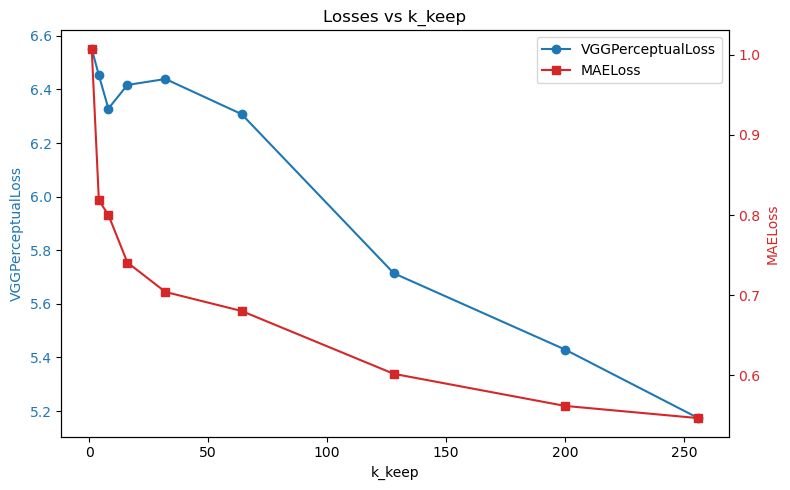

: 

In [ ]:
print("Results:", results)
import matplotlib.pyplot as plt

# Your data
results = {
    1:   {'VGGPerceptualLoss': 6.55149, 'MAELoss': 1.00754},
    4:   {'VGGPerceptualLoss': 6.45292, 'MAELoss': 0.81836},
    8:   {'VGGPerceptualLoss': 6.32839, 'MAELoss': 0.80011},
    16:  {'VGGPerceptualLoss': 6.41661, 'MAELoss': 0.74068},
    32:  {'VGGPerceptualLoss': 6.43883, 'MAELoss': 0.70390},
    64:  {'VGGPerceptualLoss': 6.30786, 'MAELoss': 0.68016},
    128: {'VGGPerceptualLoss': 5.71396, 'MAELoss': 0.60167},
    200: {'VGGPerceptualLoss': 5.42940, 'MAELoss': 0.56161},
    256: {'VGGPerceptualLoss': 5.17359, 'MAELoss': 0.54638},
}

# Prepare data lists
ks = sorted(results.keys())
vgg = [results[k]['VGGPerceptualLoss'] for k in ks]
mae = [results[k]['MAELoss']             for k in ks]

# Create plot
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(ks, vgg, color='tab:blue', marker='o', label='VGGPerceptualLoss')
ax1.set_xlabel('k_keep')
ax1.set_ylabel('VGGPerceptualLoss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Twin axis for MAE Loss
ax2 = ax1.twinx()
ax2.plot(ks, mae, color='tab:red', marker='s', label='MAELoss')
ax2.set_ylabel('MAELoss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Optional: Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('Losses vs k_keep')
plt.tight_layout()
plt.show()
